# Class Activation Maps in PyTorch
This notebook shows how to output class activation maps (CAMs) for pretrained Pytorch models

In [220]:
from torchvision.models import resnet18, resnet50, inception_v3
import numpy as np
import torchvision.transforms as transforms
from PIL import Image
import json
import torch
from urllib import request
from PyTorch_CAM import CAM 
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [221]:
import json

imnet = json.load(open("imagenet_class_index.json"))

# Load model and image

hooking ResNet


(-0.5, 479.5, 264.5, -0.5)

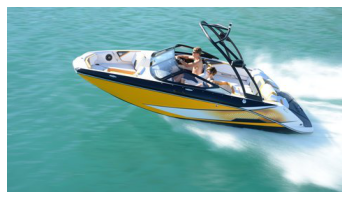

In [281]:
# Load a model
resnet = resnet50(pretrained=True).cuda()
resnet = resnet.eval()
# Initialize the CAM module
cam_resnet = CAM(resnet)
# Load an Image 
img = Image.open("jet_boat2.jpeg")
plt.imshow(img)
plt.axis("off")

In [282]:
inception = inception_v3(pretrained=True).cuda()
inception=inception.eval()
# Initialize the CAM module
cam_inception = CAM(inception)

hooking Inception3


# Define Augmentations

In [224]:
# img = cam_out
# Define Augmentation steps. Important: Preserve your cropped image for later visualization
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
PIL_tops = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224)])
tensor_tops = transforms.Compose([transforms.ToTensor(), normalize])


# Overlay Image with CAM

Top-3 classes are: [(814, ['n04273569', 'speedboat']), (625, ['n03662601', 'lifeboat']), (693, ['n03873416', 'paddle'])]


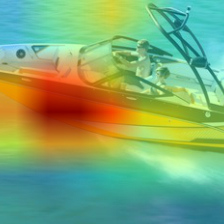

In [226]:
cropped_img = PIL_tops(img)
trans_img = tensor_tops(cropped_img)

# Feed Image to model and get top-3 classes
out=resnet(trans_img.unsqueeze(0).cuda())
print("Top-3 classes are: {}".format([(c, imnet[str(c)]) for c in torch.topk(out,3)[1].cpu().numpy()[0]]))
cam_out = cam_resnet.visualize(814,cropped_img,alpha=1, f=0.5)
cam_out

Top-3 classes are: [(814, ['n04273569', 'speedboat']), (895, ['n04552348', 'warplane']), (404, ['n02690373', 'airliner'])]


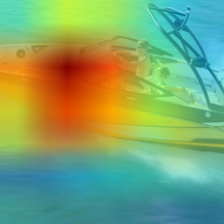

In [227]:
# Feed Image to model and get top-3 classes
trans_img = tensor_tops(cam_out)
out=inception(trans_img.unsqueeze(0).cuda())
print("Top-3 classes are: {}".format([(c, imnet[str(c)]) for c in torch.topk(out,3)[1].cpu().numpy()[0]]))
cam_out = cam_inception.visualize(814,cam_out,alpha=1, f=0.5)
cam_out

In [292]:
from matplotlib import cm

def remove_transparency(im, bg_colour=(255, 255, 255)):

    # Only process if image has transparency 
    if im.mode in ('RGBA', 'LA') or (im.mode == 'P' and 'transparency' in im.info):

        # Need to convert to RGBA if LA format due to a bug in PIL 
        alpha = im.convert('RGBA').split()[-1]

        # Create a new background image of our matt color.
        # Must be RGBA because paste requires both images have the same format

        bg = Image.new("RGBA", im.size, bg_colour + (255,))
        bg.paste(im, mask=alpha)
        return bg

    else:
        return im

def make_patch(original, patch_source, cam, cam_f, alpha, mask_threshold):
    cam[cam < cam_f] = 0
    f = np.zeros((cam.shape[0], cam.shape[1], 3))
    f[:, :, 2] = alpha * cam
    cam = np.concatenate((np.expand_dims(cam, 2), f), 2).astype("uint8")
    for i in range(cam.shape[0]):
        for j in range(cam.shape[1]):
            cam[i, j, 0:3] = np.array(cm.jet(cam[i, j, 0]))[0:3] * 255
    # convert activation map to the full image size overlay
    FILTER = Image.BILINEAR
    overlay = Image.fromarray(cam).resize((int(cam_out.size[0]), int(cam_out.size[1])), FILTER)
    # make it gray-scale
    gs_overlay = remove_transparency(overlay).convert('L')
    # convert it into mask
    mask = np.array(gs_overlay, dtype='uint8')
    mask[mask < mask_threshold] = 1
    mask[mask >= mask_threshold] = 0
    overlay = Image.fromarray(data.astype('uint8') * 255, mode='L').convert('1')
    result = original.copy()
    result.paste(patch_source, (0, 0), overlay)
    return result

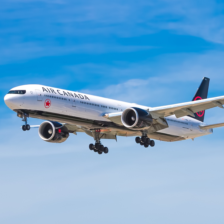

In [297]:
img = Image.open('airplane.jpeg')
patch_img = PIL_tops(img)
patch_img

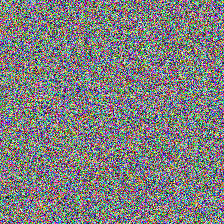

In [300]:
patch_noize = Image.fromarray(np.random.randint(0,255,(data.shape[0],data.shape[1],3),dtype=np.dtype('uint8')))
patch_noize

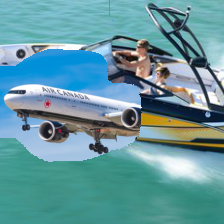

In [311]:
test = make_patch(cropped_img, patch_img, cam_resnet.generateCAM(814, numpy=True), cam_f = 50, alpha=1, mask_threshold=64)
test.save('test.jpg')
test

In [306]:
trans_img = tensor_tops(test)

out=resnet(trans_img.unsqueeze(0).cuda())
print("Top-3 classes are: {}".format([(c, imnet[str(c)]) for c in torch.topk(out,3)[1].cpu().numpy()[0]]))

Top-3 classes are: [(814, ['n04273569', 'speedboat']), (484, ['n02981792', 'catamaran']), (693, ['n03873416', 'paddle'])]


In [ ]:
dete

In [138]:
mask = np.fromfunction(lambda i, j: (i >= 5) * (j >= 5), (10, 10), dtype=int)

array([[128., 128., 128., ..., 175., 175., 175.],
       [128., 128., 128., ..., 175., 175., 175.],
       [128., 128., 128., ..., 175., 175., 175.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

# Display only CAM

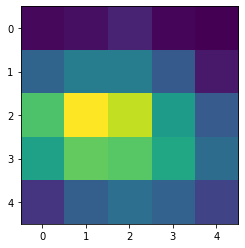

In [36]:
cam = cam_inception.generateCAM(404).cpu()
plt.imshow(cam)
# plt.axis("off")

## Test adversarial

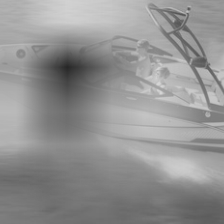

In [109]:
grayscale = transforms.Grayscale(num_output_channels=3)
gs_image = grayscale(cam_out)
gs_image

In [110]:
gs_image.save("ex5.jpg")

In [111]:
gs_image_t = tensor_tops(gs_image)
out=model(gs_image_t.unsqueeze(0).cuda())
print("Top-3 classes are: {}".format([imnet[str(c)] for c in torch.topk(out,3)[1].cpu().numpy()[0]]))


Top-3 classes are: [['n04273569', 'speedboat'], ['n04285008', 'sports_car'], ['n02965783', 'car_mirror']]


In [309]:
import boto3
import io

rekognition_client = boto3.client('rekognition')
def detect_labels(image, max_labels):
    """
    Detects labels in the image. Labels are objects and people.

    :param max_labels: The maximum number of labels to return.
    :return: The list of labels detected in the image.
    """
    try:
        in_mem_file = io.BytesIO()
        image.save(in_mem_file, format="jpeg")
        image_json = {'Bytes': in_mem_file.getvalue()}
        response = rekognition_client.detect_labels(
            Image=image_json, MaxLabels=max_labels)
        labels = response['Labels']
    except ClientError:
        logger.info("Couldn't detect labels in %s.", self.image_name)
        raise
    else:
        return labels

detect_labels(test, 6)

NameError: name 'ClientError' is not defined